In [148]:
import math
import sys
import numpy as np  # linear algebra
from scipy.stats import randint
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt  # this is used for the plot the graph 
import matplotlib.dates as mdates
import seaborn as sns  # used for plot interactive graph. 
from sklearn.model_selection import train_test_split  # to split the data into two parts
#from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler  # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline  # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics  # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error, r2_score
from datetime import timedelta

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
#from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dropout
from custom_transforms.transforms import *

df = pd.read_csv('../input/teresopolis-2016-2023-precos-medios.csv', sep=',',
                 parse_dates={'dt': ['Ano', 'Mês', 'Dia']},
                 low_memory=False, na_values=['nan', '?'], index_col='dt')

filtered_alface_crespa_roca = df[df['Produto'] == 'Alface Crespa - Roça'][['Preco_unitario']]
filtered_alface_crespa_roca = filtered_alface_crespa_roca.resample('W').mean()
filtered_alface_crespa_roca = filtered_alface_crespa_roca.interpolate(method='linear')
filtered_alface_crespa_roca.index = filtered_alface_crespa_roca.index.tz_localize("UTC")
filtered_alface_crespa_roca.sort_values(by=['dt'], inplace=True)
filtered_alface_crespa_roca[
    "first_day_week"] = filtered_alface_crespa_roca.index - filtered_alface_crespa_roca.index.weekday * timedelta(
    days=1)




weather_df = pd.read_csv('../processed_data/weather_2016_2023.csv', index_col=0)
weather_df.index = pd.to_datetime(weather_df.index, utc=True)
weather_df.drop(columns=['x'], inplace=True)

weather_df = weather_df[(weather_df.index >= '2016-04-24') & (weather_df.index <= '2023-09-24')]
weather_weekly_df = pd.DataFrame(
    weather_df.resample('W').mean())
weather_weekly_df["first_day_week"] = (weather_weekly_df.index - weather_weekly_df.index.weekday * timedelta(days=1))


price_weather_df = pd.merge(filtered_alface_crespa_roca, weather_weekly_df, on='first_day_week', how='left')
price_weather_df.index = filtered_alface_crespa_roca.index

#for col in weather_df.columns:
#    weather_df[col] = weather_df[col].replace(-9999, None)

<Axes: xlabel='dt'>

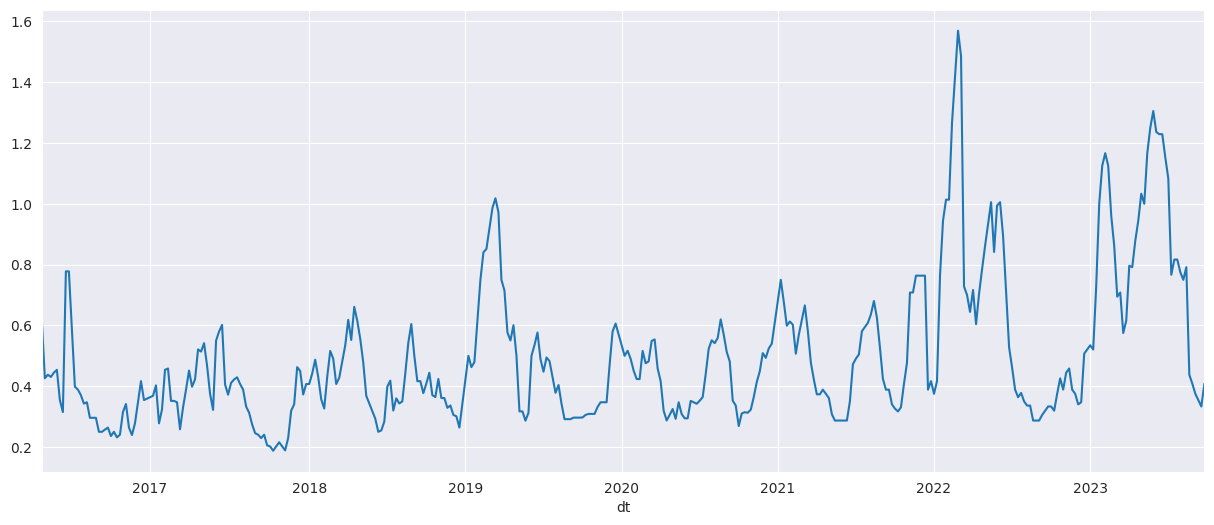

In [149]:
price_weather_df['Preco_unitario'].plot(figsize=(15, 6))

In [150]:
price_weather_df.columns

Index(['Preco_unitario', 'first_day_week', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'TEMPERATURA DO PONTO DE ORVALHO (°C)',
       'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)'],
      dtype='object')

In [151]:
#plot correlation matrix
price_weather_df['Preco_unitario_shift_-1'] = price_weather_df['Preco_unitario'].shift(-1)
price_weather_df['Preco_unitario_shift_-2'] = price_weather_df['Preco_unitario'].shift(-2)
price_weather_df['Preco_unitario_shift_-3'] = price_weather_df['Preco_unitario'].shift(-3)
price_weather_df['Preco_unitario_shift_-4'] = price_weather_df['Preco_unitario'].shift(-4)
price_weather_df['Preco_unitario_shift_-5'] = price_weather_df['Preco_unitario'].shift(-5)
price_weather_df['Preco_unitario_shift_-6'] = price_weather_df['Preco_unitario'].shift(-6)
price_weather_df['Preco_unitario_shift_-7'] = price_weather_df['Preco_unitario'].shift(-7)
price_weather_df['Preco_unitario_shift_-8'] = price_weather_df['Preco_unitario'].shift(-8)
price_weather_df['Preco_unitario_shift_-9'] = price_weather_df['Preco_unitario'].shift(-9)
price_weather_df['Preco_unitario_shift_-10'] = price_weather_df['Preco_unitario'].shift(-10)
price_weather_df['Preco_unitario_shift_-11'] = price_weather_df['Preco_unitario'].shift(-11)
price_weather_df['Preco_unitario_shift_-12'] = price_weather_df['Preco_unitario'].shift(-12)

cor = price_weather_df.corr(method="spearman")

<Figure size 640x480 with 0 Axes>

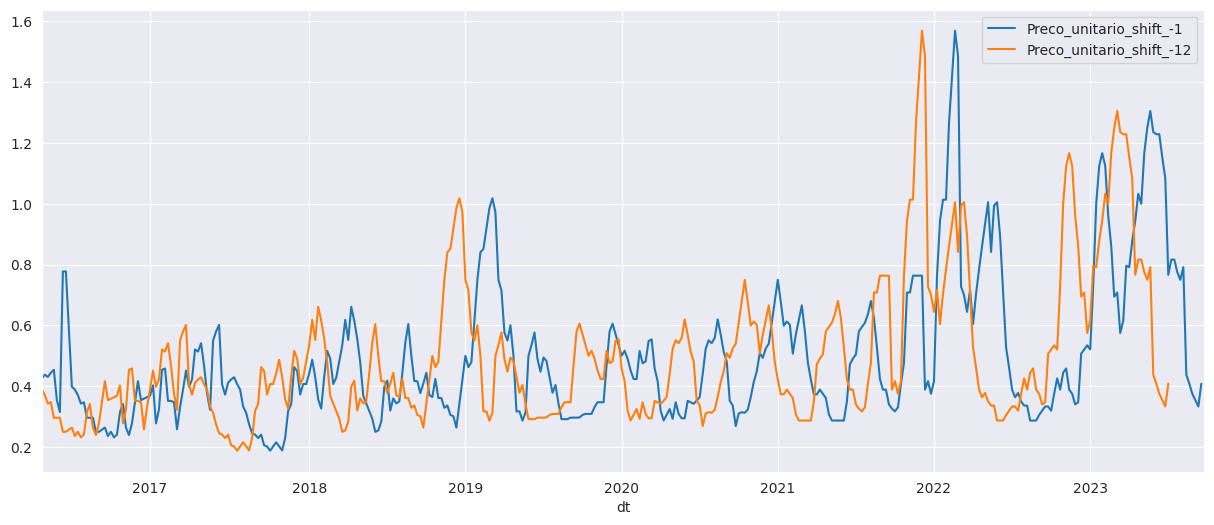

<Figure size 640x480 with 0 Axes>

In [152]:
price_weather_df['Preco_unitario_shift_-1'].plot(figsize=(15, 6), legend=True)
price_weather_df['Preco_unitario_shift_-12'].plot(figsize=(15, 6),legend=True)
plt.figure()

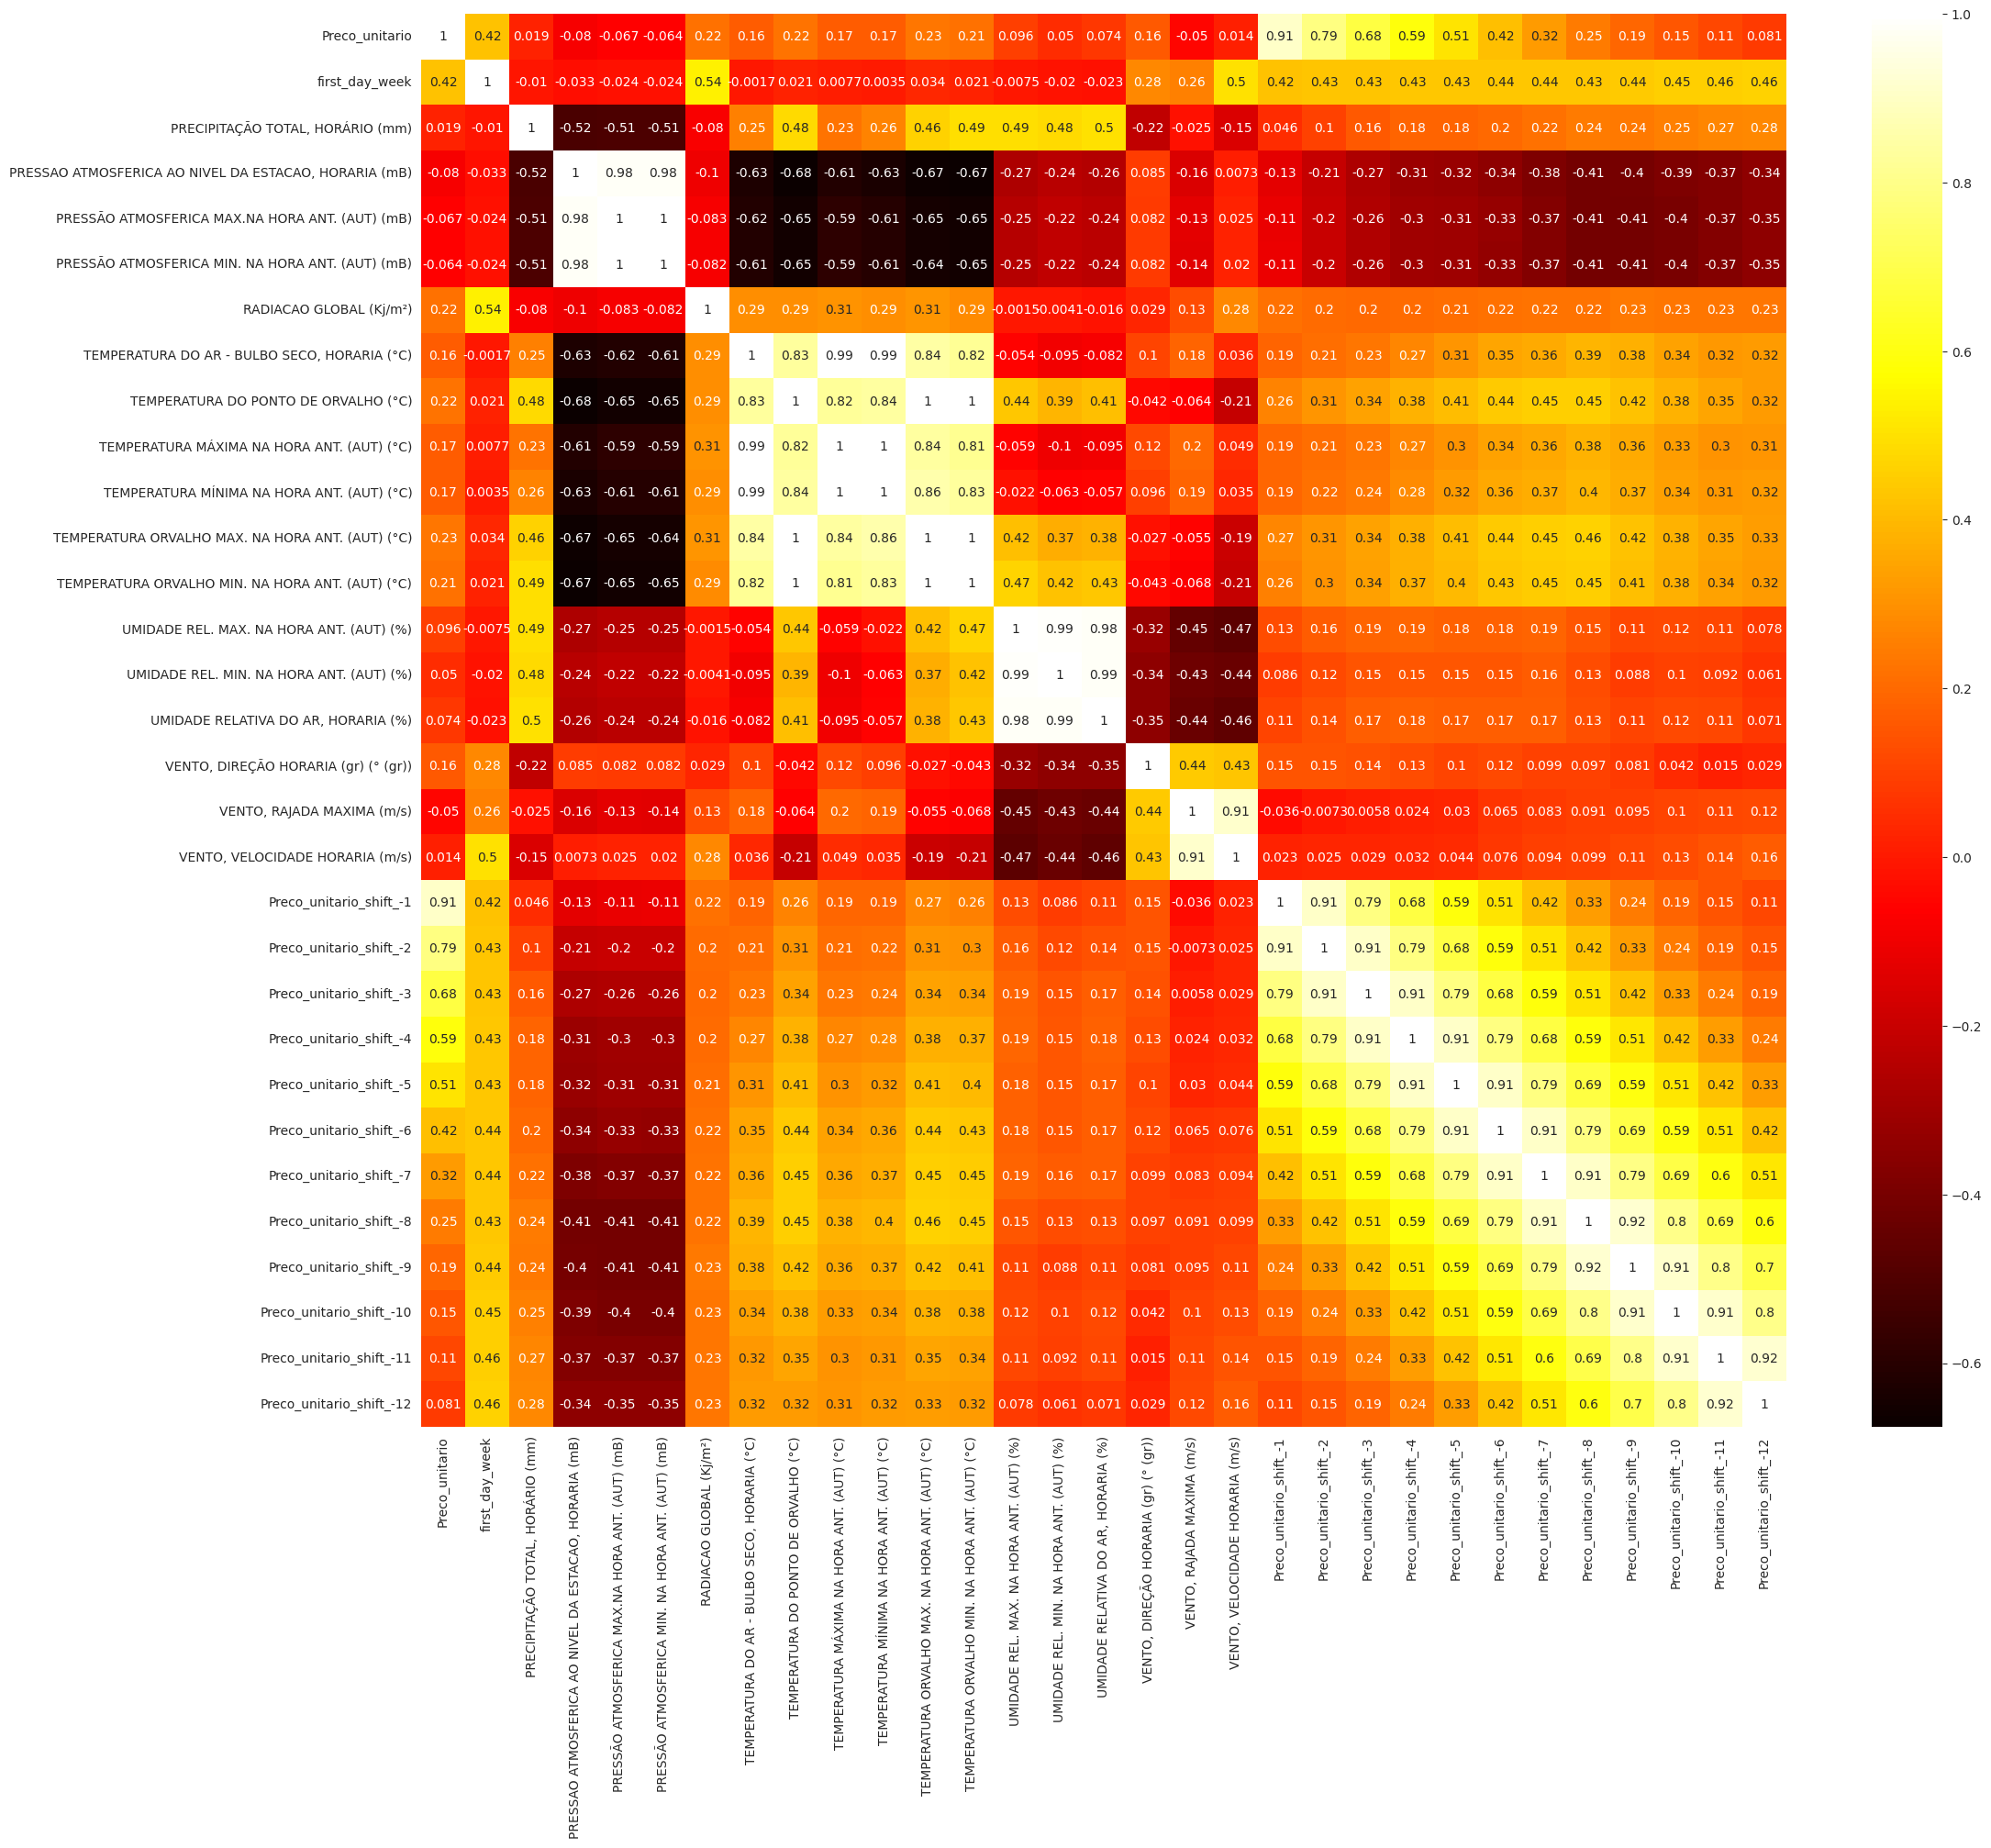

In [153]:
plt.figure(figsize=(24, 20))
sns.heatmap(cor,  cmap=plt.cm.hot, annot=True)
plt.show()

In [154]:

s = pd.Series(price_weather_df['Preco_unitario'])

In [155]:
l = (weather_df["RADIACAO GLOBAL (Kj/m²)"] == -9999)


In [156]:
missing_df_mask = pd.DataFrame()
cols_with_missing_values = []
missing_values_by_col_dict_list = []
for col in weather_df.columns:
    df_missing = weather_df[[col]][(weather_df[col] == -9999)]
    missing_df_mask[col] = (weather_df[col] == -9999)
    if len(df_missing) > 10:
        cols_with_missing_values.append(col)
        print(col)
        print(len(df_missing))
        print(len(df_missing) / len(weather_df))
        
        missing_values_by_col_dict_list.append({'col': col, 'missing_values': len(df_missing), 'missing_values_ratio': len(df_missing) / len(weather_df)})
        
        print('-------------------')




RADIACAO GLOBAL (Kj/m²)
11041
0.16981712475198793
-------------------
TEMPERATURA DO PONTO DE ORVALHO (°C)
1102
0.016949413230385898
-------------------
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)
1160
0.017841487610932526
-------------------
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)
1160
0.017841487610932526
-------------------
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)
1154
0.017749204054324254
-------------------
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)
1154
0.017749204054324254
-------------------
UMIDADE RELATIVA DO AR, HORARIA (%)
1102
0.016949413230385898
-------------------


In [157]:
missing_values_by_col_df = pd.DataFrame(missing_values_by_col_dict_list)
missing_values_by_col_df

,col,missing_values,missing_values_ratio
0,RADIACAO GLOBAL (Kj/m²),11041,0.169817
1,TEMPERATURA DO PONTO DE ORVALHO (°C),1102,0.016949
2,TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),1160,0.017841
3,TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),1160,0.017841
4,UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),1154,0.017749
5,UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),1154,0.017749
6,"UMIDADE RELATIVA DO AR, HORARIA (%)",1102,0.016949


<Axes: xlabel='col'>

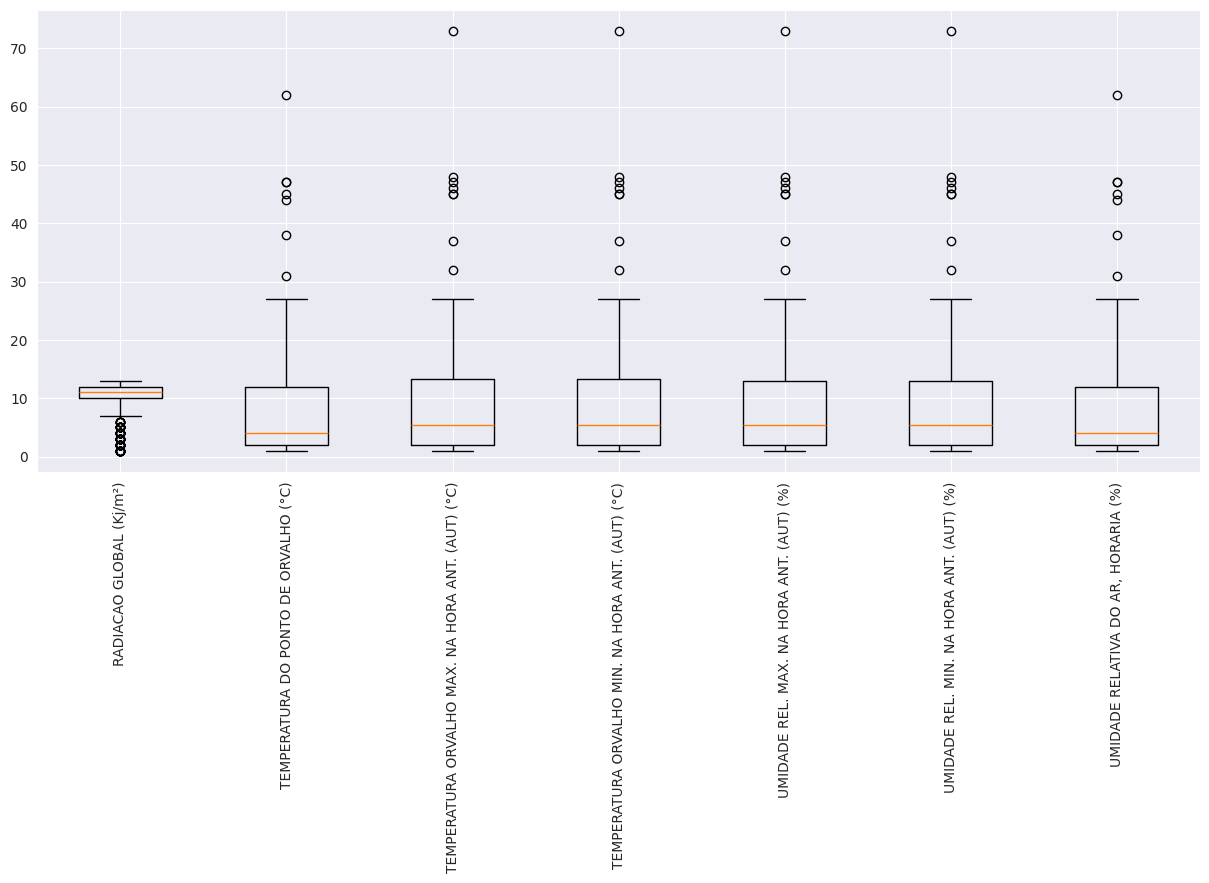

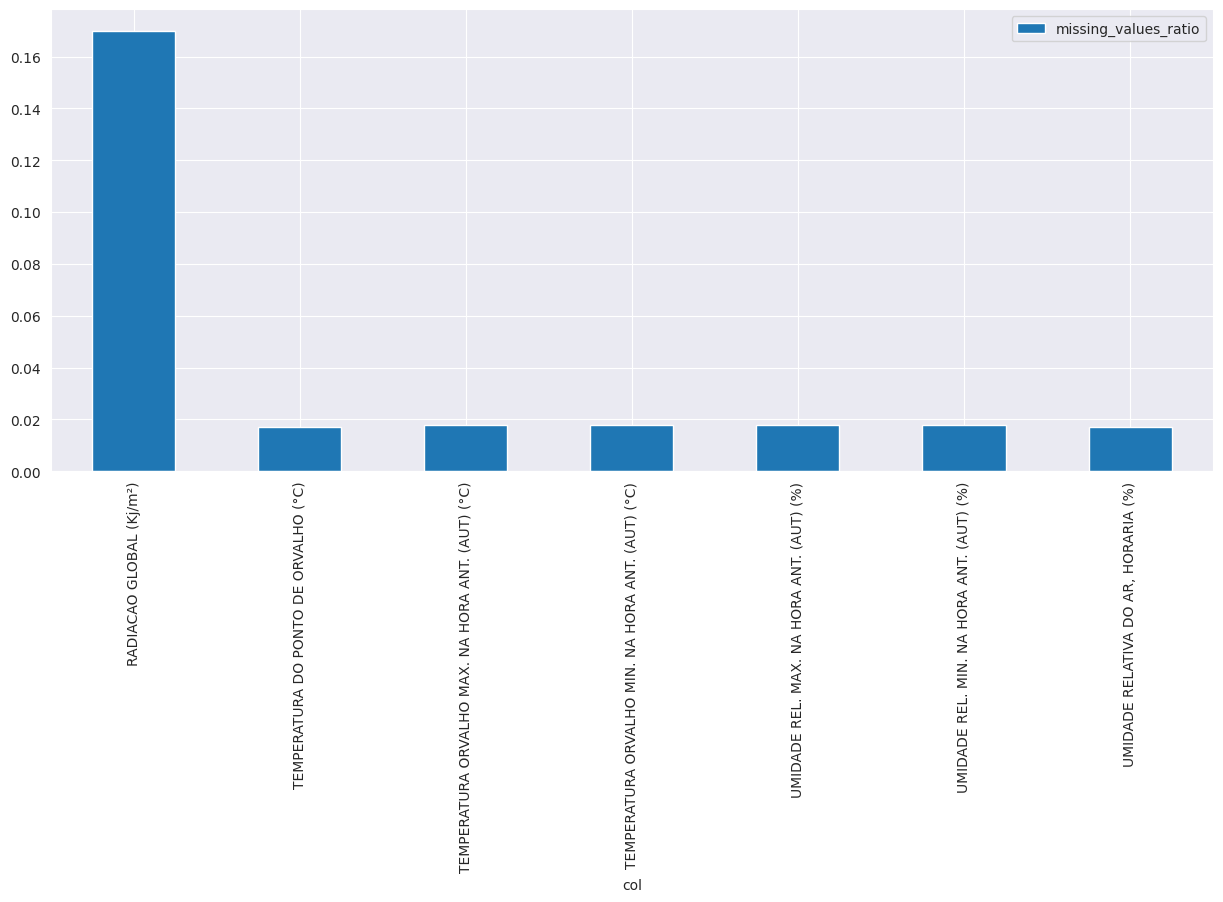

In [158]:
missing_block_sizes = {}
missing_df_mask

for col in missing_values_by_col_df['col']:
    missing_block_sizes[col] = []
    values = missing_df_mask[col].values
    count = 0
    for v in values:
        if v:
            count += 1
        else:
            if count > 0:
                missing_block_sizes[col].append(count)
                count = 0
                
    #missing_block_sizes[col] = pd.Series(missing_block_sizes[col])
    
plt.figure(figsize=(15, 6))
plt.boxplot(missing_block_sizes.values(), labels=missing_block_sizes.keys())
plt.xticks(rotation=90)

missing_values_by_col_df.plot(kind='bar', x='col', y='missing_values_ratio', figsize=(15, 6))


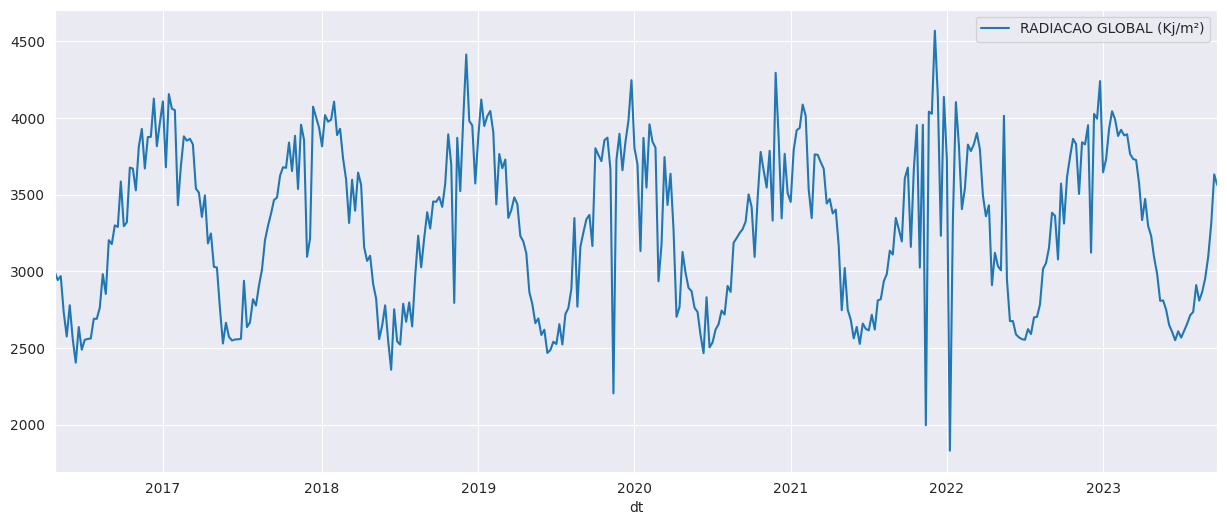

In [159]:
#for col in weather_df.columns:
    #weather_df[col] = weather_df[col].replace(-9999, None)
weather_df[['RADIACAO GLOBAL (Kj/m²)']].resample('W').max().plot(figsize=(15, 6))
plt.show()

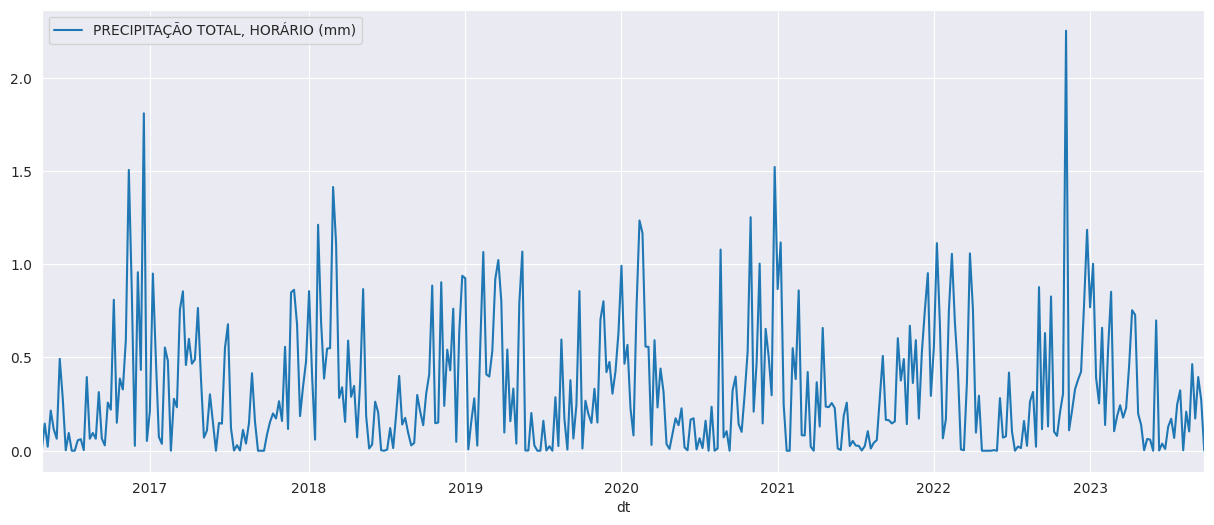

In [160]:
weather_df[['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']].resample('W').mean().plot(figsize=(15, 6))
plt.show()

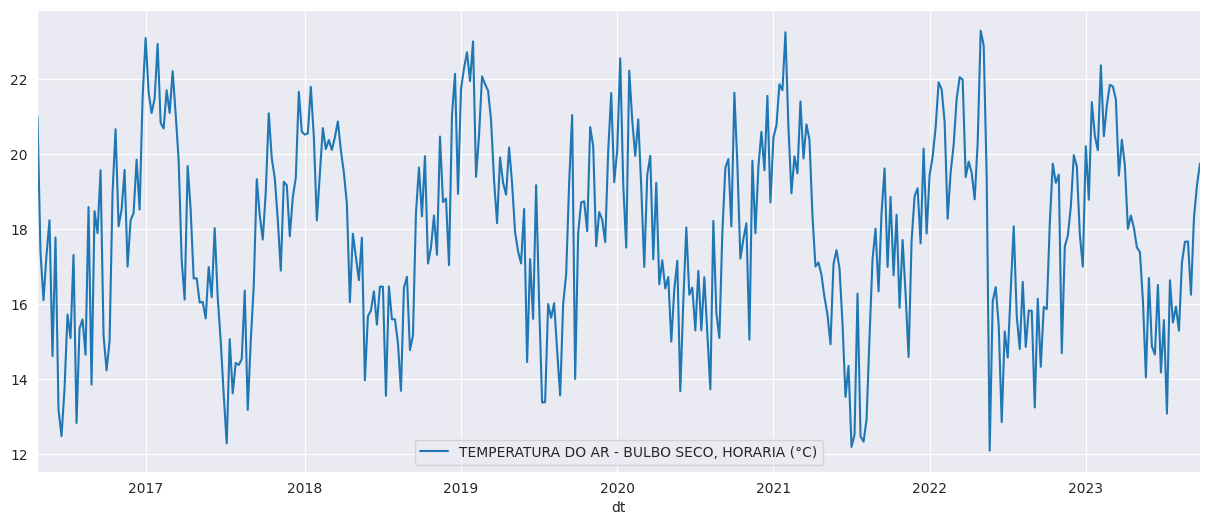

In [161]:
weather_df[['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']].resample('W').mean().plot(figsize=(15, 6))
plt.show()

In [162]:
for col in weather_df.columns:
    weather_df[col] = weather_df[col].replace(-9999, None)

In [163]:
price_series = pd.Series(price_weather_df[['Preco_unitario']].values[:, 0])


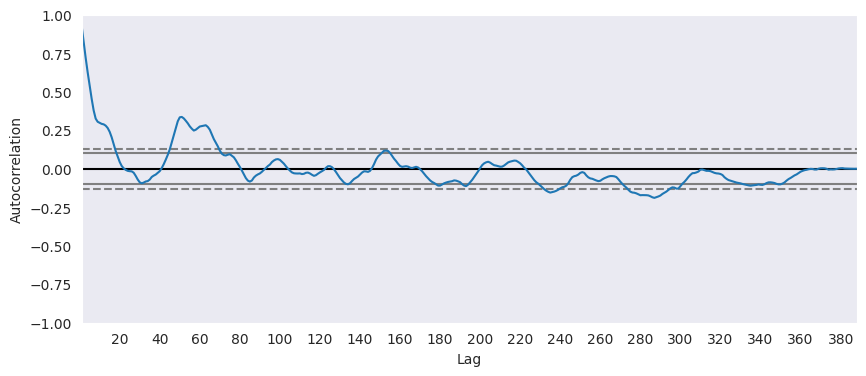

In [164]:
plt.figure(figsize=(10, 4))
plt.xticks(range(0, len(price_series), 20),  rotation=0)
pd.plotting.autocorrelation_plot(price_series)

plt.show()